# 2025 Polish Presidential Elections: Electorate flows and anomalies

This short notebook analyses the results of the 2025 Polish Presidential election to address two questions:

* How did voters for first-round eliminated candidates vote in the run-off? How does this compare with exit poll results?
* Based on this, where can anomalies be detected in second-round voting?

To examine voter behaviour, I use simple OLS regression in four variants: with and without coefficient restrictions, and with and without random effects. The results broadly align with exit poll findings.

I then use fitted values to identify large residuals and detect anomalies, confirming those reported in previous studies. However, their scale is limited and unlikely to have influenced the final election outcome.

## Data

In [197]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

from statsmodels.regression.linear_model import OLS
from scipy.optimize import lsq_linear
from scipy.stats import norm
from IPython.display import clear_output
from statsmodels.graphics.gofplots import qqplot

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)

I start by importing the official voting results from National Electorate Comission (Państwowa Komisja Wybrocza) and IPSOS exit poll results on electorate flows.

In [198]:
df_round_1 = pd.read_csv('data//electorial_district_protocols_round_1.csv', encoding='utf8', sep=';')
df_round_2 = pd.read_csv('data//electorial_district_protocols_round_2.csv', encoding='utf8', sep=';')
ipsos_results = pd.read_csv('data//ipsos_exit_poll.csv', encoding='utf8', index_col=0)

In [199]:
display(df_round_1.head())

Nr komisji           Gmina  Teryt Gminy         Powiat  Teryt Powiatu  \
0           1  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
1           2  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
2           3  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
3           4  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
4           5  m. Bolesławiec      20101.0  bolesławiecki        20100.0   

    Województwo                                           Siedziba Typ obwodu  \
0  dolnośląskie  Szkoła Podstawowa Nr 3, ul. Ceramiczna 5, 59-7...      stały   
1  dolnośląskie  Szkoła Podstawowa Nr 3, ul. Ceramiczna 5, 59-7...      stały   
2  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   
3  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   
4  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   

  Typ obszaru  \
0      miasto   
1      miasto   
2      miasto   
3      miasto   
4      miasto   

   Liczba kart do głosowania otrzymanych przez obwodową komisję wyborczą, ustalona po ich przeliczeniu przed rozpoczęciem głosowania z uwzględnieniem ewentualnych kart otrzymanych z rezerwy  \
0                                             1622.0                                                                                                                                            
1                                             1295.0                                                                                                                                            
2                                             1324.0                                                                                                                                            
3                                             1360.0                                                                                                                                            
4                                             1222.0                                                                                                                                            

   Liczba wyborców uprawnionych do głosowania (umieszczonych w spisie, z uwzględnieniem dodatkowych formularzy) w chwili zakończenia głosowania  \
0                                             1640.0                                                                                              
1                                             1293.0                                                                                              
2                                             1364.0                                                                                              
3                                             1378.0                                                                                              
4                                             1214.0                                                                                              

   Liczba niewykorzystanych kart do głosowania  \
0                                        559.0   
1                                        414.0   
2                                        398.0   
3                                        441.0   
4                                        403.0   

   Liczba wyborców, którym wydano karty do głosowania w lokalu wyborczym (liczba podpisów w spisie oraz adnotacje o wydaniu karty bez potwierdzenia podpisem w spisie)  \
0                                             1063.0                                                                                                                     
1                                              881.0                                                                                                                     
2                                              926.0                                                   

In [200]:
display(df_round_2.head())

Nr komisji           Gmina  Teryt Gminy         Powiat  Teryt Powiatu  \
0           1  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
1           2  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
2           3  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
3           4  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
4           5  m. Bolesławiec      20101.0  bolesławiecki        20100.0   

    Województwo                                           Siedziba Typ obwodu  \
0  dolnośląskie  Szkoła Podstawowa Nr 3, ul. Ceramiczna 5, 59-7...      stały   
1  dolnośląskie  Szkoła Podstawowa Nr 3, ul. Ceramiczna 5, 59-7...      stały   
2  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   
3  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   
4  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   

  Typ obszaru  \
0      miasto   
1      miasto   
2      miasto   
3      miasto   
4      miasto   

   Liczba kart do głosowania otrzymanych przez obwodową komisję wyborczą, ustalona po ich przeliczeniu przed rozpoczęciem głosowania z uwzględnieniem ewentualnych kart otrzymanych z rezerwy  \
0                                             1627.0                                                                                                                                            
1                                             1296.0                                                                                                                                            
2                                             1324.0                                                                                                                                            
3                                             1363.0                                                                                                                                            
4                                             1211.0                                                                                                                                            

   Liczba wyborców uprawnionych do głosowania (umieszczonych w spisie, z uwzględnieniem dodatkowych formularzy) w chwili zakończenia głosowania  \
0                                             1678.0                                                                                              
1                                             1269.0                                                                                              
2                                             1358.0                                                                                              
3                                             1354.0                                                                                              
4                                             1195.0                                                                                              

   Liczba niewykorzystanych kart do głosowania  \
0                                        440.0   
1                                        386.0   
2                                        329.0   
3                                        379.0   
4                                        355.0   

   Liczba wyborców, którym wydano karty do głosowania w lokalu wyborczym (liczba podpisów w spisie oraz adnotacje o wydaniu karty bez potwierdzenia podpisem w spisie)  \
0                                             1187.0                                                                                                                     
1                                              910.0                                                                                                                     
2                                              995.0                                                   

In [201]:
display(ipsos_results)

NAWROCKI Karol Tadeusz  \
BARTOSZEWICZ Artur                            0.673   
BIEJAT Magdalena Agnieszka                    0.098   
BRAUN Grzegorz Michał                         0.925   
HOŁOWNIA Szymon Franciszek                    0.138   
JAKUBIAK Marek                                0.903   
MACIAK Maciej                                 0.729   
MENTZEN Sławomir Jerzy                        0.881   
NAWROCKI Karol Tadeusz                        0.993   
SENYSZYN Joanna                               0.189   
STANOWSKI Krzysztof Jakub                     0.512   
TRZASKOWSKI Rafał Kazimierz                   0.010   
WOCH Marek Marian                             0.654   
ZANDBERG Adrian Tadeusz                       0.162   
New voters                                    0.486   

                             TRZASKOWSKI Rafał Kazimierz  
BARTOSZEWICZ Artur                                 0.327  
BIEJAT Magdalena Agnieszka                         0.902  
BRAUN Grzegorz Michał                              0.075  
HOŁOWNIA Szymon Franciszek                         0.862  
JAKUBIAK Marek                                     0.097  
MACIAK Maciej                                      0.271  
MENTZEN Sławomir Jerzy                             0.119  
NAWROCKI Karol Tadeusz                             0.007  
SENYSZYN Joanna                                    0.811  
STANOWSKI Krzysztof Jakub                          0.488  
TRZASKOWSKI Rafał Kazimierz                        0.990  
WOCH Marek Marian                                  0.346  
ZANDBERG Adrian Tadeusz                            0.838  
New voters                                         0.514

I find that the lengths of the two dataframes are equal, suggesting that voting districts likely overlap across both datasets—this would significantly simplify data cleaning.

To confirm this, I check whether the following administrative identifiers match across both datasets:
- `Nr komisji` (district number)
- `Gmina` (municipality)
- `Powiat` (county)
- `Województwo` (voivodeship)
- `Teryt Gminy` (municipality code)
- `Teryt Powiatu` (county code)

A perfect match across these fields would confirm that records align at the voting district level.

In [202]:
len(df_round_1) == len(df_round_2)

True

In [203]:
control_cols = ['Nr komisji', 'Gmina', 'Teryt Gminy', 'Powiat', 'Teryt Powiatu', 'Województwo']
(df_round_1[control_cols] == df_round_2[control_cols]).all()

Nr komisji        True
Gmina             True
Teryt Gminy      False
Powiat           False
Teryt Powiatu    False
Województwo      False
dtype: bool

It is the case only for `Nr komisji` (district number) and `Gmina` (munipacity), but not the other columns. Hence, I check in which `Typ obwodu` (district type) the discrapency arises:

In [204]:
teryt_gminy_discrapency_idx = np.where(df_round_1['Teryt Gminy'] != df_round_2['Teryt Gminy'])
display(df_round_1.loc[teryt_gminy_discrapency_idx]['Typ obwodu'].unique())
display(df_round_2.loc[teryt_gminy_discrapency_idx]['Typ obwodu'].unique())

array(['statek', 'zagranica'], dtype=object)

array(['statek', 'zagranica'], dtype=object)

This mismatch occurs only for districts located on a vessel (`statek`) and abroad (`zagranica`). Further analysis reveals that in these cases, the columns `Teryt Gminy`, `Powiat`, `Teryt Powiatu`, and `Województwo` all contain `NaN` values, which are not comparable by definition.

As this issue is limited to a small number of special-purpose districts and does not affect domestic precincts with complete administrative data, we can safely ignore it and proceed with data cleaning.

In [205]:
df_round_1[df_round_1['Typ obwodu'].isin(('statek', 'zagranica'))][['Teryt Gminy', 'Powiat', 'Teryt Powiatu', 'Województwo']].isna().all()

Teryt Gminy      True
Powiat           True
Teryt Powiatu    True
Województwo      True
dtype: bool

As a next step, I merge two dataframes into one.

In [206]:
categorical_cols = df_round_1.columns[:9]
turnout_cols_1 = df_round_1.columns[[10, 23, 31]]
invalid_votes_cols_1 = df_round_1.columns[[25, 27]]
candidates_cols_1 = df_round_1.columns[-13:]
categorical_colseng = ['District number', 'Gmina', 'Gmina teritorial code', 'Powiat', 'Powiat teritorial code', 'Wojewodztwo', 'Town', 'District type', 'Area type']

df = df_round_1[categorical_cols]
df[['Eligible to vote 1', 'Total votes 1', 'Valid votes 1']] = df_round_1[turnout_cols_1].values
df['Invalid votes 1'] = df_round_1[invalid_votes_cols_1].sum(axis=1).values
df[candidates_cols_1 + ' 1'] = df_round_1[candidates_cols_1].values

turnout_cols_2 = df_round_2.columns[[10, 23, 30]]
invalid_votes_cols_2 = df_round_2.columns[[25, 27]]
candidates_cols_2 = df_round_2.columns[-2:]

df[['Eligible to vote 2', 'Total votes 2', 'Valid votes 2']] = df_round_2[turnout_cols_2].values
df['Invalid votes 2'] = df_round_2[invalid_votes_cols_2].sum(axis=1).values
df[candidates_cols_2 + ' 2'] = df_round_2[candidates_cols_2].values

In [207]:
df.head()

Nr komisji           Gmina  Teryt Gminy         Powiat  Teryt Powiatu  \
0           1  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
1           2  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
2           3  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
3           4  m. Bolesławiec      20101.0  bolesławiecki        20100.0   
4           5  m. Bolesławiec      20101.0  bolesławiecki        20100.0   

    Województwo                                           Siedziba Typ obwodu  \
0  dolnośląskie  Szkoła Podstawowa Nr 3, ul. Ceramiczna 5, 59-7...      stały   
1  dolnośląskie  Szkoła Podstawowa Nr 3, ul. Ceramiczna 5, 59-7...      stały   
2  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   
3  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   
4  dolnośląskie  Szkoła Podstawowa Nr 5, ul. Dolne Młyny 60, 59...      stały   

  Typ obszaru  Eligible to vote 1  Total votes 1  Valid votes 1  \
0      miasto              1640.0         1063.0         1059.0   
1      miasto              1293.0          882.0          880.0   
2      miasto              1364.0          927.0          922.0   
3      miasto              1378.0          919.0          916.0   
4      miasto              1214.0          819.0          813.0   

   Invalid votes 1  BARTOSZEWICZ Artur 1  BIEJAT Magdalena Agnieszka 1  \
0              4.0                   2.0                          32.0   
1              2.0                   6.0                          29.0   
2              5.0                   1.0                          28.0   
3              3.0                   5.0                          28.0   
4              6.0                   6.0                          31.0   

   BRAUN Grzegorz Michał 1  HOŁOWNIA Szymon Franciszek 1  JAKUBIAK Marek 1  \
0                     66.0                          50.0               6.0   
1                     37.0                          29.0               5.0   
2                     61.0                          51.0               4.0   
3                     40.0                          47.0               3.0   
4                     47.0                          39.0               2.0   

   MACIAK Maciej 1  MENTZEN Sławomir Jerzy 1  NAWROCKI Karol Tadeusz 1  \
0              2.0                     200.0                     287.0   
1              2.0                     113.0                     228.0   
2              1.0                     123.0                     241.0   
3              1.0                     119.0                     217.0   
4              4.0                      87.0                     202.0   

   SENYSZYN Joanna 1  STANOWSKI Krzysztof Jakub 1  \
0               10.0                         10.0   
1                9.0                         13.0   
2                9.0                          7.0   
3               13.0                         18.0   
4               12.0                         10.0   

   TRZASKOWSKI Rafał Kazimierz 1  WOCH Marek Marian 1  \
0                          361.0                  1.0   
1                          381.0                  1.0   
2                          356.0                  1.0   
3                          390.0                  2.0   
4                          343.0                  1.0   

   ZANDBERG Adrian Tadeusz 1  Eligible to vote 2  Total votes 2  \
0                       32.0              1678.0         1187.0   
1                       27.0              1269.0          911.0   
2                       39.0              1358.0          996.0   
3                       33.0              1354.0          984.0   
4                       29.0              1195.0          856.0   

   Valid votes 2  Invalid votes 2  NAWROCKI Karol Tadeusz 2  \
0         1178.0              9.0                     582.0   
1          903.0              8.0                     386.0   
2          993.0              3.0          

In [208]:
type_group = df[['Typ obwodu', 'Total votes 1', 'Total votes 2']].groupby('Typ obwodu').sum()
(type_group / type_group.sum(axis=0)).style.format('{:.3%}')

Above is the breakdown of voting districts by type. Nearly 97% are permanent (`stały`), which will be the focus of this study moving forward.

Districts abroad (`zagranica`) are excluded due to significant voter rotation caused by travel, making vote differences unrepresentative of actual electorate flows.

Other district types (e.g. `szpital`, `areszt`, `statek`) account for less than 1% of total votes. These cover small, specific populations—such as those in prisons, hospitals, or care homes—and are excluded to avoid distortion due to limited sample sizes.

Focusing solely on permanent districts ensures more stable and representative comparisons.

In [209]:
df = df[df['Typ obwodu'] == 'stały']

In [210]:
prop_small_districts = df[df['Valid votes 1'] < 100]['Valid votes 1'].sum() / df['Valid votes 1'].sum()
print(f'{prop_small_districts:.2%}')

0.15%


Finally, I exclude permanent districts with fewer than 100 valid votes. These represent just 0.15% of the total vote count in permanent districts and are removed for the same reason: small sample sizes can introduce noise and distort the analysis of electorate flows.

In [211]:
df = df[df['Valid votes 1'] >= 100]

Lastly, I check if there are any missing values in our data. There are none, and this happened without using dropna() even once!

In [212]:
df.isna().any()

Nr komisji                       False
Gmina                            False
Teryt Gminy                      False
Powiat                           False
Teryt Powiatu                    False
Województwo                      False
Siedziba                         False
Typ obwodu                       False
Typ obszaru                      False
Eligible to vote 1               False
Total votes 1                    False
Valid votes 1                    False
Invalid votes 1                  False
BARTOSZEWICZ Artur 1             False
BIEJAT Magdalena Agnieszka 1     False
BRAUN Grzegorz Michał 1          False
HOŁOWNIA Szymon Franciszek 1     False
JAKUBIAK Marek 1                 False
MACIAK Maciej 1                  False
MENTZEN Sławomir Jerzy 1         False
NAWROCKI Karol Tadeusz 1         False
SENYSZYN Joanna 1                False
STANOWSKI Krzysztof Jakub 1      False
TRZASKOWSKI Rafał Kazimierz 1    False
WOCH Marek Marian 1              False
ZANDBERG Adrian Tadeusz 1

Also, let's check the the total number of votes and the total number of districts remaining after the cleaning.

In [213]:
df[['Valid votes 1', 'Valid votes 2']].sum().to_frame('Sum').style.format('{:,.0f}')

In [214]:
print(f'Number of electorate districts: {len(df):,.0f}')

Number of electorate districts: 29,472


## Voting results in relevant data

In [215]:
round_1_results = (df[candidates_cols_1 + ' 1'].sum() / df[candidates_cols_1 + ' 1'].sum().sum()).sort_values(ascending=False)
round_1_results.name = 'Total round 1'
display(round_1_results.to_frame().style.format('{:.2%}'))

In [216]:
round_2_results = (df[candidates_cols_2 + ' 2'].sum() / df[candidates_cols_2 + ' 2'].sum().sum())
round_2_results.name = 'Total round 2'
display(round_2_results.to_frame().style.format('{:.2%}'))

The cleaned dataset closely reflects the overall voting results. The only notable deviation is a slightly higher level of support for Nawrocki in the 2nd round of voting, which appears after excluding votes cast abroad. This is expected, as overseas voters tend to show different voting patterns compared to the domestic electorate.

## Generating clusters

The next step is to generate clusters for use in random effects models. The motivation behind clustering is that electorate flows—especially among those who did not vote in the first round—may vary significantly across different geographies. As using voivodeship (województwo) level clustering would not capture urban-rural differences in voting, while using county (powiat) level clustering would result in too small sample sizes (as there are over 370 of them in Poland) with many random effects very similar across powiats, I will use the following logic to generate the clusters:

- **Powiat Classification**  
  Each *powiat* (county-level unit, ~300,000 inhabitants on average) is assigned to one of four categories:
  - **Central**: A *miasto wojewódzkie* (voivodeship capital).
  - **Bordering**: A *powiat* bordering a Central one, often with significant commuter populations (especially around Warsaw). This category is not assigned in the Silesian voivodeship (województwo Śląskie) due to a sparse population distribution in the metropolitan area. 
  - **City**: A medium-sized urban area defined as *miasto na prawach powiatu* (city with powiat rights) which is not a Central city.
  - **Rural**: All remaining counties, typically more agricultural and less densely populated.

- **Cluster Assignment**  
  Each *powiat* category is then paired with its corresponding *województwo* (province-level unit, ~2.4 million inhabitants on average).  
  For example, *m. Warszawa* is classified as **Mazowieckie–Central**.

This hierarchical clustering approach ensures geographic and demographic relevance, improving the reliability of random effects estimates in later modelling.

In [217]:
def get_central_cities():
    url = "https://pl.wikipedia.org/wiki/Kategoria:Miasta_wojew%C3%B3dzkie"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
    
    city_links = soup.select('#mw-pages li a')
    cities = [link.text for link in city_links]
    return cities

def get_cities():
    url = "https://pl.wikipedia.org/wiki/Miasto_na_prawach_powiatu"
    tables = pd.read_html(url)
    
    city_table = tables[0]
    cities = city_table.iloc[:, 0].tolist()
    return cities

central_cities = get_central_cities()
cities = get_cities()
cities = np.setdiff1d(cities, central_cities)
bordering_powiats = ['policki', 'goleniowski', 'stargardzki',
                     'gorzowski', 'zielonogórski', 'nowosolski',
                     'wrocławski',
                     'poznański',
                     'opolski',
                     'gdański',
                     'bydgoski', 'toruński',
                     'zgierski', 'pabianicki', 'łódzki wschodni',
                     'olsztyński',
                     'legionowski', 'warszawski zachodni', 'pruszkowski', 'piaseczyński', 'otwocki', 'miński', 'wołomiński',
                     'kielecki',
                     'krakowski', 'wielicki',
                     'rzeszowski',
                     'lubelski', 'świdnicki',
                     'białostocki']

def categorise_powiat(powiat):
    if powiat in central_cities:
        return 'Central'
    elif powiat in cities:
        return 'City'
    elif powiat in bordering_powiats:
        return 'Bordering'
    else:
        return 'Rural'

In [218]:
df['County category'] = df['Powiat'].apply(categorise_powiat)
df['Cluster'] = df['Województwo'] + '_' + df['County category']

In [219]:
min_cluster_votes = df.groupby('Cluster')['Valid votes 1'].sum().min() 
min_cluster = df.groupby('Cluster')['Valid votes 1'].sum().idxmin() 
min_cluster_districts = df.groupby('Cluster')['Valid votes 1'].count().min() 
min_cluster_count = df.groupby('Cluster')['Valid votes 1'].count().idxmin()

print(f'Min votes per cluster: {min_cluster_votes:,.0f} in {min_cluster}')
print(f'Min votes per cluster: {min_cluster_districts:,.0f} in {min_cluster_count}')

Min votes per cluster: 50,500 in opolskie_Bordering
Min votes per cluster: 56 in warmińsko-mazurskie_City


In [220]:
min_powiat_votes = df.groupby('Powiat')['Valid votes 1'].sum().min() 
min_powiat = df.groupby('Powiat')['Valid votes 1'].sum().idxmin() 
min_powiat_districts = df.groupby('Powiat')['Valid votes 1'].count().min() 
min_powiat_count = df.groupby('Powiat')['Valid votes 1'].count().idxmin()

print(f'Min votes per cluster: {min_powiat_votes:,.0f} in {min_powiat}')
print(f'Min votes per cluster: {min_powiat_districts:,.0f} in {min_powiat_count}')

Min votes per cluster: 8,176 in sejneński
Min votes per cluster: 21 in Sopot


As shown, creating clusters instead of estimating random effects for each of the 370+ individual *powiats* significantly improves sample distribution. Specifically, the minimum sample size per group increases nearly threefold—from 21 to 56.

This enhances the reliability of random effects estimation by reducing noise and improving statistical robustness within each cluster.

In [221]:
df.groupby('County category')[['Valid votes 1', 'Valid votes 2']].sum().sort_values('Valid votes 1', ascending=False).style.format('{:,.0f}')

In [222]:
round_1_results_groupped = (df.groupby('County category')[candidates_cols_1 + ' 1'].sum().T / df.groupby('County category')['Valid votes 1'].sum())
round_1_results_groupped = round_1_results_groupped.join(round_1_results)
round_1_results_groupped.loc[round_1_results.index].style.format('{:.2%}').background_gradient(axis=None, cmap='YlOrRd')

In [223]:
round_2_results_groupped = (df.groupby('County category')[candidates_cols_2 + ' 2'].sum().T / df.groupby('County category')['Valid votes 2'].sum())
round_2_results_groupped = round_2_results_groupped.join(round_2_results)
round_2_results_groupped.loc[round_2_results.index].style.format('{:.2%}').background_gradient(axis=None, cmap='YlOrRd')

## Model

### Method 1: OLS

The first method estimates vote flows by regressing the second-round result of one candidate—Nawrocki (chosen arbitrarily, as his name appeared first on the ballot)—on the first-round results of all candidates, plus the number of new voters in each district.

To simplify the model and avoid overfitting, votes for the four lowest-polling first-round candidates are aggregated into a single category. Given their minimal support, this aggregation has no meaningful effect on the results.

The regression is estimated using heteroskedasticity-robust standard errors to account for potential variance differences across districts.

In [224]:
df['Abstained 1'] = df['Eligible to vote 1'] - df['Valid votes 1']
df['Abstained 2'] = df['Eligible to vote 2'] - df['Valid votes 2']
df['New voters 2'] = df['Valid votes 2'] - df['Valid votes 1']
others_cols = ['BARTOSZEWICZ Artur 1', 'JAKUBIAK Marek 1', 'MACIAK Maciej 1', 'WOCH Marek Marian 1']
df['Others 1'] = df[others_cols].sum(axis=1)

In [225]:
y_var = 'NAWROCKI Karol Tadeusz 2'

x_var = ['BIEJAT Magdalena Agnieszka 1',
         'BRAUN Grzegorz Michał 1', 
         'HOŁOWNIA Szymon Franciszek 1', 
         'MENTZEN Sławomir Jerzy 1',
         'NAWROCKI Karol Tadeusz 1', 
         'SENYSZYN Joanna 1',
         'STANOWSKI Krzysztof Jakub 1', 
         'TRZASKOWSKI Rafał Kazimierz 1',
         'ZANDBERG Adrian Tadeusz 1',
         'Others 1',
         'New voters 2']

Y, X = df[y_var], df[x_var]
model_ols = OLS(Y, X).fit()

In [226]:
alpha = 0.05

params_summary = pd.DataFrame([model_ols.params,
                               model_ols.params - model_ols.HC0_se * norm.ppf(1 - alpha / 2),
                               model_ols.params + model_ols.HC0_se * norm.ppf(1 - alpha / 2)
                              ],
                              index=['coef',
                                     f'[{alpha / 2:.3f}',
                                     f'{1 - alpha / 2:.3f}]'
                                    ]).T
params_summary.style.format('{:.1%}').background_gradient(axis=0, subset='coef', cmap='YlOrRd', vmin=0, vmax=1)

Observations from the Regression Results:
- For most candidates, the estimated vote flows align reasonably well with the exit poll results.
- However, the estimated flow from Adrian Zandberg voters and new voters to Nawrocki is notably lower than indicated by the exit poll.
- Additionally, some coefficients fall outside the rational bounds for vote shares:
  - A negative coefficient for Trzaskowski and Zandberg suggests an implausible vote shift *away* from Nawrocki.
  - A coefficient exceeding 100% for Nawrocki’s own first-round voters implies over-attribution, which is not feasible.

These anomalies point to limitations of the unconstrained OLS model, motivating further refinement using restrictions or random effects.

In [227]:
y = Y.sum()
y_hat = X.sum().dot(model_ols.params)
ae = np.abs(y_hat - y)
ape = ae / y

print(f'Y_hat:  \t{y_hat:,.0f}')
print(f'Y:      \t{Y.sum():,.0f}')
print(f'Abs error:  \t{ae:,.0f}')
print(f'Abs % error: \t{ape:.3%}')

Y_hat:  	10,290,479
Y:      	10,307,686
Abs error:  	17,207
Abs % error: 	0.167%


In [228]:
def get_r2(y: pd.Series, y_hat: pd.Series):
    tss = ((y - y.mean()) ** 2).sum()
    rss = ((y - y_hat) ** 2).sum()
    return 1 - (rss / tss)

r2 = get_r2(X.dot(model_ols.params), Y)
print(f'R2: {r2:.2%}')

R2: 99.42%


OLS estimates tend to fit the data well.

### Method 2: Restricted OLS

This approach follows the same logic as the standard OLS model but imposes natural constraints on the parameters: all coefficients are bounded between 0 and 1, reflecting valid proportions of vote flows.

Estimation is performed using a least squares technique with bounds, implemented via the `lsq_linear` module from `scipy`.

To account for uncertainty in the estimates, I compute confidence intervals using bootstrapping. This provides a more realistic measure of variability, especially in the presence of non-normal residuals or small sample sizes.

In [229]:
def estimate_model(df, x_var, y_var):
    params = lsq_linear(df[x_var], df[y_var], bounds=[0, 1], tol=0.5).x
    params = pd.Series(params, index=x_var)
    return params

In [230]:
B = 200
frac = 0.35
resols_params_df = pd.DataFrame(index=x_var)
for i in range(B):
    df_sample = df.sample(frac=frac)
    params_bound = estimate_model(df_sample, x_var, y_var)
    resols_params_df = pd.concat([resols_params_df, params_bound], axis=1)
    
    clear_output()
    print(f'{(i + 1) / B:.1%} done')

100.0% done


In [231]:
alpha = 0.05

params_summary = pd.DataFrame([resols_params_df.mean(axis=1),
                               resols_params_df.quantile(alpha / 2, axis=1),
                               resols_params_df.quantile(1 - alpha / 2, axis=1)
                              ],
                              index=['coef',
                                     f'[{alpha / 2:.3f}',
                                     f'{1 - alpha / 2:.3f}'
                                    ]).T
params_summary.style.format('{:.1%}').background_gradient(axis=0, subset='coef', cmap='YlOrRd', vmin=0, vmax=1)

The estimated coefficients tend to cluster near the boundaries—either close to 0% or 100%—with few intermediate values. As a result, they often fail to reflect the more nuanced vote flows reported in the exit poll.

This outcome likely stems from the imposed constraints, which can push estimates to the extremes when multicollinearity or limited variation exists among predictors. While the model enforces logical bounds, it may oversimplify actual voter behaviour.

In [232]:
y_hat = X.sum().dot(resols_params_df.mean(axis=1))
ae = np.abs(y_hat - y)
ape = ae / y

print(f'Y_hat:  \t{y_hat:,.0f}')
print(f'Y:      \t{Y.sum():,.0f}')
print(f'Abs error:  \t{ae:,.0f}')
print(f'Abs % error: \t{ape:.3%}')

Y_hat:  	10,213,826
Y:      	10,307,686
Abs error:  	93,860
Abs % error: 	0.911%


In [233]:
r2 = get_r2(X.dot(resols_params_df.mean(axis=1)), Y)
print(f'R2: {r2:.2%}')

R2: 98.71%


Although the R-squared remains relatively high, the fitted values still miss the actual result by nearly 100,000 votes—highlighting a substantial aggregate error.

This suggests that unobserved heterogeneity across regions may be influencing voting behaviour in ways not captured by the model.

To address this, I proceed to estimate a model with random effects, which allows for variation in vote flows across geographic clusters.

### Method 3: Random Effect OLS

In this approach, OLS coefficients are estimated separately within each geographic cluster. These cluster-specific estimates are then aggregated to form overall coefficients by weighting them according to the number of valid first-round votes in each cluster.

Standard errors are computed using a similar logic—assuming independence between clusters and heteroskedasticity within clusters.
<br><br>
$E[\theta_i] = \sum_c \theta_{ci}(n_c/N)$<br>
$Std(\theta_i) = \sqrt{\sum_c Var(\theta_{ci})(n_c/N)^2}$<br><br>
Where<br>
$\theta_i$ is flow from candidate $i$ to Nawrocki<br>
$\theta_{ci}$ is from from candidate $i$ to Nawrocki in cluster $c$<br>
$n_c$ is number of valid votes in round 1 in cluster $c$<br>
$N$ is the total number of valid votes

In [234]:
cluster_col = 'Cluster'
clusters = df[cluster_col].unique()

reols_params_df = pd.DataFrame(index=x_var, columns=clusters)
reols_fitted_vals = pd.Series(index=df.index, name=y_var + 'RE OLS Hat')
reols_se_df = pd.DataFrame(index=x_var, columns=clusters)
n_series = pd.Series(index=clusters)

for cluster in clusters:
    df_cluster = df[df[cluster_col] == cluster]
    model = OLS(df_cluster[y_var], df_cluster[x_var]).fit()
    reols_params_df[cluster] = model.params
    reols_fitted_vals.loc[df_cluster.index] = model.fittedvalues    
    reols_se_df[cluster] = model.HC0_se
    n_series.loc[cluster] = df_cluster['Valid votes 1'].sum()

In [235]:
def get_weighted_estimates(params_df: pd.DataFrame, se_df: pd.DataFrame, n_series: pd.Series):
    country_categories = df['County category'].unique()
    params_weighted = pd.DataFrame(index=x_var, columns = ['Overall'] + list(country_categories))
    se_weighted = params_weighted.copy()
    
    cluster_weights = n_series / n_series.sum()
    params_weighted['Overall'] = params_df.dot(cluster_weights)
    se_weighted['Overall'] = np.sqrt((se_df ** 2).dot(cluster_weights ** 2))
    
    for county_category in country_categories:
        county_category_cols = df['Województwo'].unique() + '_' + county_category
        county_category_cols = np.intersect1d(county_category_cols, params_df.columns)
        
        cluster_weights = n_series.loc[county_category_cols] / n_series.loc[county_category_cols].sum()
        params_weighted[county_category] = params_df[county_category_cols].dot(cluster_weights)
        se_weighted[county_category] = np.sqrt((se_df[county_category_cols] ** 2).dot(cluster_weights ** 2))

    return params_weighted, se_weighted

def get_summary_df(params_weighted: pd.DataFrame, se_weighted: pd.DataFrame, alpha: float):
    clusters = ['Overall', 'Central', 'Bordering', 'City', 'Rural']
    
    values = ['coef', f'[{alpha / 2:.3f}', f'{1 - alpha / 2:.3f}]']
    columns = pd.MultiIndex.from_product([clusters, values])
    params_summary = pd.DataFrame(index=x_var, columns=columns)
    
    for cluster in clusters:
        params_summary[cluster, values[0]] = params_weighted[cluster]
        params_summary[cluster, values[1]] = params_weighted[cluster] - se_weighted[cluster] * norm.ppf(1 - alpha / 2)
        params_summary[cluster, values[2]] = params_weighted[cluster] + se_weighted[cluster] * norm.ppf(1 - alpha / 2)

    params_summary_styled = params_summary.style
    
    coef_cols = [col for col in params_summary.columns if col[1] == 'coef']
    params_summary_styled = params_summary_styled.background_gradient(axis=1, subset=coef_cols, cmap='YlOrRd', vmin=0, vmax=1)
    params_summary_styled = params_summary_styled.set_table_styles([{'selector': 'th.col_heading.level0', 'props': [('text-align', 'center')]}], overwrite=False)
    params_summary_styled = params_summary_styled.format('{:.1%}')
    
    return params_summary_styled

In [236]:
reols_params_weighted, reols_se_weighted = get_weighted_estimates(reols_params_df, reols_se_df, n_series)

alpha = 0.05
reols_params_summary = get_summary_df(reols_params_weighted, reols_se_weighted, alpha)

reols_params_summary

Several conclusions can be drawn from the cluster-weighted estimates:

- Coefficients for Zandberg, Senyszyn, and new voters are now much closer to exit poll results, suggesting better model calibration across regions.
- Estimates for Nawrocki and Trzaskowski still fall outside rational bounds (e.g. negative or >100%), indicating that even with clustering, some vote flows are not well identified.
- Voters of Mentzen, Senyszyn, Stanowski, Zandberg, and new voters were more likely to support Nawrocki in rural areas, highlighting significant regional patterns in voter behaviour.

These findings validate the use of random effects but also point to remaining modelling challenges, particularly in cases of strong candidate polarisation.

In [237]:
y_hat = X.sum().dot(reols_params_weighted['Overall'])
ae = np.abs(y_hat - y)
ape = ae / y

print(f'Y_hat:  \t{y_hat:,.0f}')
print(f'Y:      \t{Y.sum():,.0f}')
print(f'Abs error:  \t{ae:,.0f}')
print(f'Abs % error: \t{ape:.3%}')

Y_hat:  	10,314,918
Y:      	10,307,686
Abs error:  	7,232
Abs % error: 	0.070%


In [238]:
r2 = get_r2(reols_fitted_vals, Y)
print(f'R2: {r2:.2%}')

R2: 99.51%


The absolute error has halved as well, further pointing to increased model accuracy.

### Method 4: Random Effects Restricted OLS

In the final approach, I estimate restricted OLS separately within each cluster. The overall coefficients are then computed by aggregating cluster-level estimates, weighted by the number of valid first-round votes in each cluster, analogous to the method used in the unrestricted random effects model.

In [239]:
cluster_col = 'Cluster'

clusters = df[cluster_col].unique()
reresols_params_df = pd.DataFrame(index=x_var, columns=clusters)
reresols_fitted_vals = pd.Series(index=df.index, name=y_var + 'RE Restricted OLS Hat')
n_series = pd.Series(index=clusters)

for cluster in clusters:
    df_cluster = df[df[cluster_col] == cluster]
    params = lsq_linear(df_cluster[x_var], df_cluster[y_var], bounds=[0, 1], tol=0.5).x
    params = pd.Series(params, index=x_var)
    reresols_fitted_vals.loc[df_cluster.index] = df_cluster[x_var].dot(params)

    reresols_params_df[cluster] = params
    n_series.loc[cluster] = df_cluster['Valid votes 1'].count()

In [240]:
def get_weighted_estimates(params_df: pd.DataFrame, n_series: pd.Series):
    country_categories = df['County category'].unique()
    params_weighted = pd.DataFrame(index=x_var, columns = ['Overall'] + list(country_categories))
    
    cluster_weights = n_series / n_series.sum()
    params_weighted['Overall'] = params_df.dot(cluster_weights)
    
    for county_category in country_categories:
        county_category_cols = df['Województwo'].unique() + '_' + county_category
        county_category_cols = np.intersect1d(county_category_cols, params_df.columns)
        
        cluster_weights = n_series.loc[county_category_cols] / n_series.loc[county_category_cols].sum()
        params_weighted[county_category] = params_df[county_category_cols].dot(cluster_weights)

    return params_weighted

In [241]:
clusters = ['Overall', 'Central', 'Bordering', 'City', 'Rural']

reresols_params_weighted = get_weighted_estimates(reresols_params_df, n_series)
reresols_params_summary = reresols_params_weighted[clusters].style.format('{:.1%}')
reresols_params_summary = reresols_params_summary.background_gradient(axis=1, cmap='YlOrRd', vmin=0, vmax=1)
reresols_params_summary

One slightly concerning outcome is that, even after enforcing rational constraints (coefficients between 0 and 1), the model suggests that approximately 3–5% of each runoff candidate’s first-round voters switched to the opponent in the second round. Given the short two-week interval between rounds, this level of defection appears relatively high and may reflect modelling limitations.

Compared to the random effects OLS model:
- The constrained model suggests fewer Stanowski and Biejat voters switched to Nawrocki.
- Conversely, it shows more Hołownia voters supporting Nawrocki in the second round.

These differences are noticeable but not dramatic, indicating general consistency across modelling approaches despite methodological differences.

In [242]:
y_hat = X.sum().dot(reresols_params_weighted['Overall'])
ae = np.abs(y_hat - y)
ape = ae / y

print(f'Y_hat:  \t{y_hat:,.0f}')
print(f'Y:      \t{Y.sum():,.0f}')
print(f'Abs error:  \t{ae:,.0f}')
print(f'Abs % error: \t{ape:.3%}')

Y_hat:  	10,296,468
Y:      	10,307,686
Abs error:  	11,218
Abs % error: 	0.109%


In [243]:
r2 = get_r2(reresols_fitted_vals, Y)
print(f'R2: {r2:.2%}')

R2: 98.82%


The fit is quite close to RE OLS and significantly better than for restricted OLS without random effects.

## Summary

In [244]:
ipsos_results_mod = ipsos_results.copy()
ipsos_results_mod.columns = ipsos_results_mod.columns + ' 2'
ipsos_results_mod = ipsos_results_mod[y_var]
ipsos_results_mod.index = [idx + ' 1' if idx != 'New voters' else idx + ' 2' for idx in ipsos_results.index]
ipsos_results_mod.loc['Others 1'] = ipsos_results_mod.loc[others_cols].dot(df[others_cols].sum()) / df[others_cols].sum().sum()
ipsos_results_mod.drop(others_cols, inplace=True)
ipsos_results_mod = ipsos_results_mod.loc[x_var]
ipsos_results_mod.name = 'IPSOS'

In [245]:
coef_ols = model_ols.params.to_frame(name='OLS')
coef_resols = resols_params_df.mean(axis=1).to_frame(name='Restricted OLS')
coef_reols = reols_params_weighted['Overall']
coef_reols.name = 'Random eff OLS'
coef_reresols = reresols_params_weighted['Overall']
coef_reresols.name = 'Random eff restricted OLS'

In [246]:
coef_summary = coef_ols.join(coef_resols).join(coef_reols).join(coef_reresols).join(ipsos_results_mod)
coef_summary.style.format('{:.1%}').background_gradient(axis=1, cmap='YlOrRd', vmin=0, vmax=1)

## Anomalies

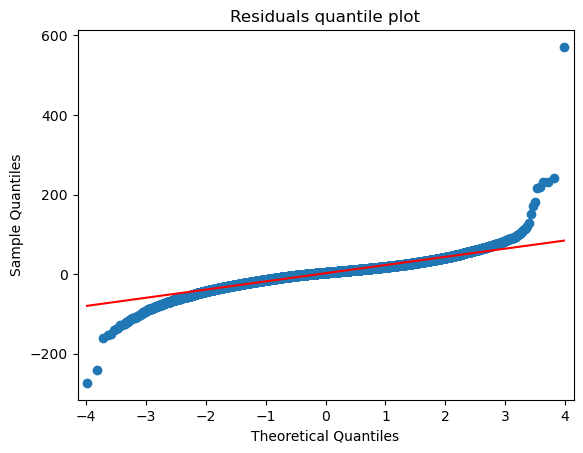

In [247]:
resid = Y - reresols_fitted_vals
resid_z = (resid - resid.mean()) / resid.std()
resid_z.name = 'Residual Z-score'
qqplot(resid, line='s')
plt.title('Residuals quantile plot')
plt.savefig('graphs//resid_qqplot.png', dpi=300)
plt.show()

The quantile plot of residuals from the fourth model indicates a long-tailed distribution. This is not unexpected, as the model is unlikely to yield normally distribiuted residuals on such a micro-level of data. A small number of widely dispersed outliers are also present.

To explore these further, I identify districts where residuals have a z-score above 5, indicating statistically unusual deviations from the model's predictions.

- A **positive residual** means the model underpredicted votes for Nawrocki in that district.
- A **negative residual** indicates the model underpredicted votes for Trzaskowski.

These residuals do not imply irregularities by themselves but highlight areas where observed results differ most from model expectations.

In [248]:
anomalies = resid_z[resid_z.abs() > 5].sort_values()
anomalies_kn = anomalies[anomalies > 0][::-1] 
anomalies_rt = anomalies[anomalies < 0]

print(f'# districts where residual in-favour of Nawrocki has >5 z-score: {len(anomalies_kn)}')
print(f'# districts where residual in-favour of Trzaskowski has >5 z-score: {len(anomalies_rt)}')

# districts where residual in-favour of Nawrocki has >5 z-score: 16
# districts where residual in-favour of Trzaskowski has >5 z-score: 30


Out of over 29,000 permanent electoral districts in Poland, only 46 districts (approximately 0.15%) exhibited a residual absolute z-score above 5. While there were slightly more anomalies in favour of Trzaskowski, the difference is marginal relative to the total number of districts.

Given the small scale and balanced distribution of these anomalies, it is reasonable to conclude that they did not materially impact the final outcome of the election.

That said, the next step is to examine which specific districts these residuals occurred in, to better understand their geographic or administrative context.

In [249]:
cols = ['Nr komisji', 
        'Gmina', 
        'Powiat', 
        'Województwo', 
        'Siedziba', 
        'NAWROCKI Karol Tadeusz 2RE OLS Hat',
        'NAWROCKI Karol Tadeusz 2',
        'TRZASKOWSKI Rafał Kazimierz 2',
        'Residual Z-score']

def highlight_selected_rows(row):
    return ['background-color: yellow' if row.name in highlight_rows else '' for _ in row]

highlight_rows = [12616, 26382,  11610, 23990, 12863, 22043, 17247, 25160, 17548, 4069]
anomaly_dist_rt = df.join(reols_fitted_vals).join(resid_z).loc[anomalies_rt.index, cols].head(10)

display(anomaly_dist_rt.style.apply(highlight_selected_rows, axis=1))

In [250]:
anomaly_dist_kn = df.join(reols_fitted_vals).join(resid_z).loc[anomalies_kn.index, cols].head(10)

display(anomaly_dist_kn.style.apply(highlight_selected_rows, axis=1))

A quick review of the districts with the 10 largest absolute residual z-scores reveals that in several cases highlighted in yellow, there was a switch of votes between two candidates (i.e. candiadate A was assigned votes of candidate B). This pattern appears more frequently in favour of Nawrocki among the top residuals. However, in many cases, the cause of the discrepancy is less clear or not attributable to a specific source. While notable, those cases remain isolated instances and do not suggest a systemic bias.